# SAR Tutorial

This tutorial shows some of the features of the SAR module. For installation of the tools, please refer to the main [README.md](../README.md). The same data set as for the tools demonstration is used.

The code is based on the [RDKit Cookbook](http://www.rdkit.org/docs/Cookbook.html) and the [paper](https://jcheminf.springeropen.com/articles/10.1186/1758-2946-5-43) by Sereina and Greg.

An example similarity map output is shown [here](./sim_map.html).

**Note:** Some features (like the progressbar) are only correctly displayed when the notebook is actually run, not when it is just displayed in NBviewer. 

In [1]:
%reload_ext autoreload
%autoreload 2
def warn(*args, **kwargs):
    pass  # to suppress sklearn warnings

import warnings
warnings.filterwarnings("ignore")
warnings.warn = warn

from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

# The next two lines are for optical reasons only. They can be safely disabled.
Draw.DrawingOptions.atomLabelFontFace = "DejaVu Sans"
Draw.DrawingOptions.atomLabelFontSize = 18

from rdkit_ipynb_tools import tools, pipeline as p, sar

misc_tools.apl_tools                          (commit: 74b38c8 ( 2016-11-16 09:13:25 ))
- no local installation of highcharts found, using web version.
rdkit_ipynb_tools.hc_tools                    (commit: e2766ed ( 2017-03-15 11:26:37 ))


Loading BokehJS ...

rdkit_ipynb_tools.tools                       (commit: e2766ed ( 2017-03-15 11:26:37 ))
- no local installation of JSME found, using web version.
> interactive IPython session.
rdkit_ipynb_tools.sar                         (commit: e2766ed ( 2017-03-15 11:26:37 ))


## Example Data Set
Endothelin Receptor A (ET-A) Antagonists from [ChEMBL](https://www.ebi.ac.uk/chembl/), downloaded as tab-separated file on 31-Aug-2016, gzipped.

### Preparation
Count the lines and display the first line

In [2]:
!zcat chembl_et-a_antagonists.txt.gz | wc -l
print()
!zcat chembl_et-a_antagonists.txt.gz | head -n 1

2324

CMPD_CHEMBLID	MOLREGNO	PARENT_CMPD_CHEMBLID	PARENT_MOLREGNO	MOL_PREF_NAME	COMPOUND_KEY	MOLWEIGHT	ALOGP	PSA	NUM_RO5_VIOLATIONS	CANONICAL_SMILES	ACTIVITY_ID	STANDARD_TYPE	RELATION	STANDARD_VALUE	STANDARD_UNITS	PCHEMBL_VALUE	ACTIVITY_COMMENT	DATA_VALIDITY_COMMENT	POTENTIAL_DUPLICATE	BAO_ENDPOINT	UO_UNITS	QUDT_UNITS	ASSAY_ID	ASSAY_CHEMBLID	ASSAY_TYPE	DESCRIPTION	ASSAY_SRC_ID	ASSAY_SRC_DESCRIPTION	ASSAY_ORGANISM	ASSAY_STRAIN	ASSAY_TAX_ID	CURATED_BY	BAO_FORMAT	TID	TARGET_CHEMBLID	TARGET_TYPE	PROTEIN_ACCESSION	PREF_NAME	ORGANISM	CONFIDENCE_SCORE	TARGET_MAPPING	APD_NAME	APD_CONFIDENCE	DOC_ID	DOC_CHEMBLID	PUBMED_ID	JOURNAL	YEAR	VOLUME	ISSUE	FIRST_PAGE	CELL_ID	CELL_CHEMBL_ID	CELL_NAME

gzip: stdout: Broken pipe


We have 2323 records and a number of fields of which we will only need a few.

### Curate the Data Set with Pipelines
Pipelines are part of the tools to deal with arbitrarily large data sets with compound-awareness. This is achieved using Python generators.<br>
We will now use a pipeline to curate the data set for our needs:
1. Read in the data set *(here directly as gzipped file, reading from multiple files is also possible)*
1. Transform the IC50 into a pIC50
1. Keep only the fields that we are interested in
1. Rename a field
1. Generate the structures from Smiles
1. Calculate some physicochemical properties
1. Finally, collect everything in a Mol_List instance

In [3]:
s = p.Summary()  # optional, used for logging what the individual components do

# code for IC50 --> pIC50 conversion
run_code = """
if "STANDARD_VALUE" in rec:
    rec["ETA_pIC50"] = tools.pic50(rec["STANDARD_VALUE"], "nM")"""  

# define the start of the pipeline, can work directly with gzipped files
rd = p.start_csv_reader("chembl_et-a_antagonists.txt.gz", summary=s)

et_a_list = p.pipe(rd,
             (p.pipe_custom_man, run_code),
             (p.pipe_keep_props, ["CMPD_CHEMBLID", "CANONICAL_SMILES", "ETA_pIC50"]),
             (p.pipe_rename_prop, "CMPD_CHEMBLID", "Chembl_Id"),
             (p.pipe_mol_from_smiles, "CANONICAL_SMILES"),
             (p.pipe_calc_props, ["2d", "LogP"]),
             (p.stop_mol_list_from_stream, {"max": 3000, "summary": s})
            )
s.update(True)

## Define Activity Classes and Split the Data Set 
Limit to Biphenyl compounds:

In [20]:
mol_list = et_a_list.has_prop_filter("ETA_pIC50").mol_filter("c2ccc(c1ccccc1)cc2")

> processed:    2292   found:   1453
> processed:    1453   found:     65


In [21]:
mol_list.summary()

In [22]:
for mol in mol_list:
    if float(mol.GetProp("ETA_pIC50")) >= 7.0:
        mol.SetProp("ActClass", "1")
    else:
        mol.SetProp("ActClass", "0")

In [23]:
train_list, test_list = mol_list.split(0.25)
print(len(train_list), len(test_list))

14 51


## Train the Model

In [24]:
model = sar.train(train_list)

## Prediction
The predicted Activity Class is put in `ActClass_Pred`, the probability in `ActClass_Prob`.

In [25]:
test_list = sar.SAR_List(test_list)
test_list.order = ["Chembl_Id", "ETA_pIC50", "ActClass", "LogP"]

test_list.model = model

In [26]:
test_list.predict()

In [27]:
_ = test_list.analyze()

Number of correctly predicted molecules: 40 / 51    (78.43%)

Correctly predicted molecules per Activity Class:
  0:  47.37
  1:  96.88


## Display as Similarity Maps

,ETA:,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#,Molecule,SimMap,Chembl_Id,ETA_pIC50,ActClass_Pred,ActClass,ActClass_Prob,LogP
0,,,CHEMBL80857,8.854,1,1,0.84,4.213
1,,,CHEMBL2058372,8.051,1,1,0.8,6.508
2,,,CHEMBL2058371,8.032,1,1,0.92,6.808
3,,,CHEMBL2058376,8.0,1,1,0.93,7.519
4,,,CHEMBL80857,7.79,1,1,0.84,4.213
5,,,CHEMBL413001,7.666,1,1,0.97,7.343
6,,,CHEMBL94446,6.991,1,0,0.78,5.673
7,,,CHEMBL11345,6.699,0,0,0.54,5.489
8,,,CHEMBL417651,6.237,1,0,0.73,3.759
9,,,CHEMBL433039,4.824,0,0,0.88,5.334

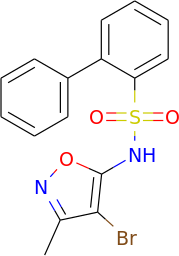
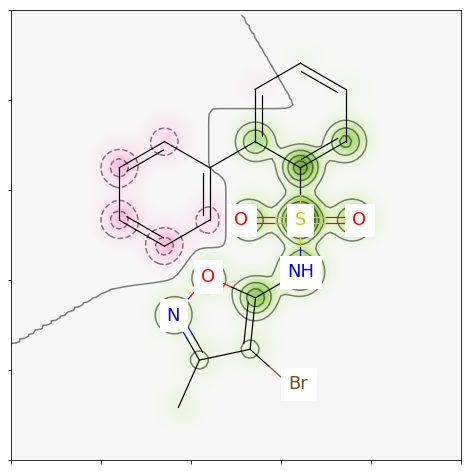
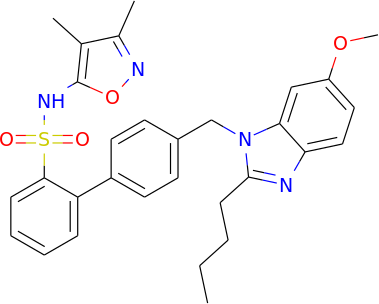
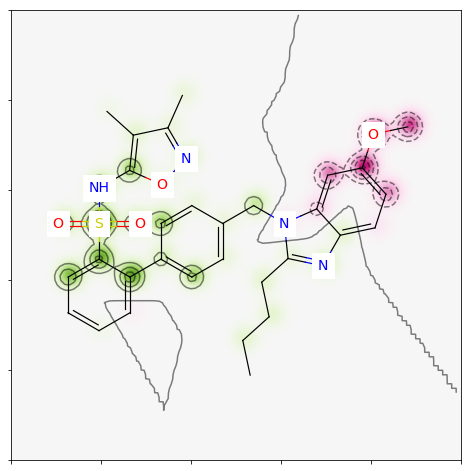
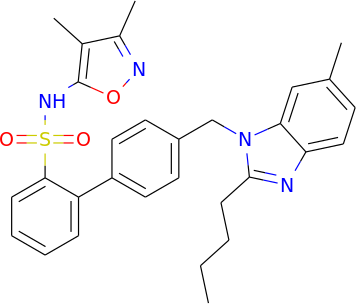
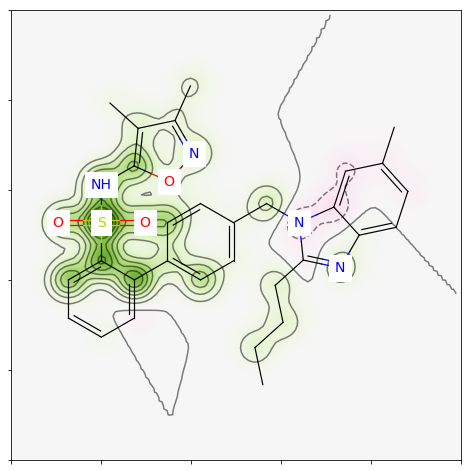
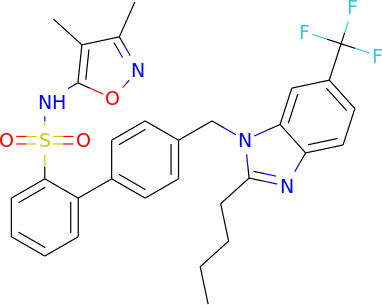
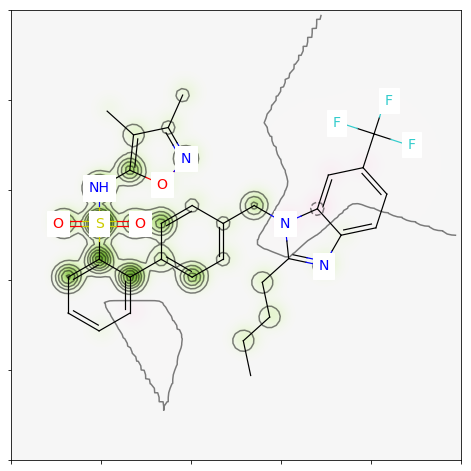
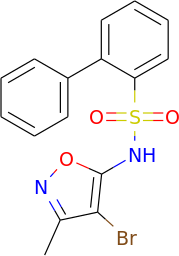
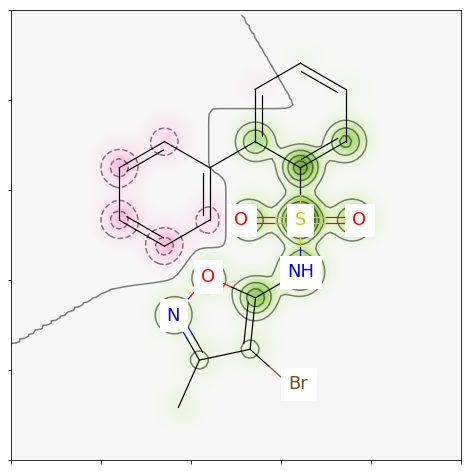
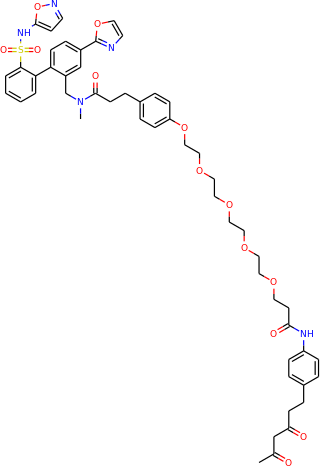
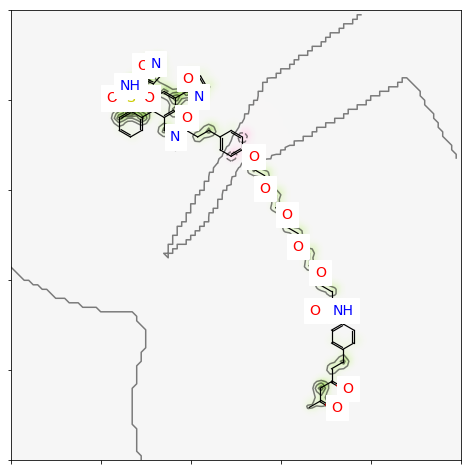
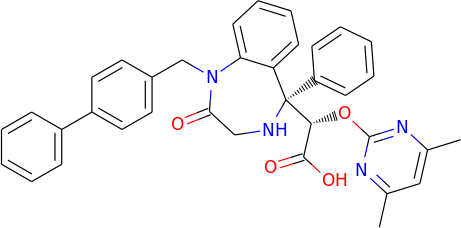
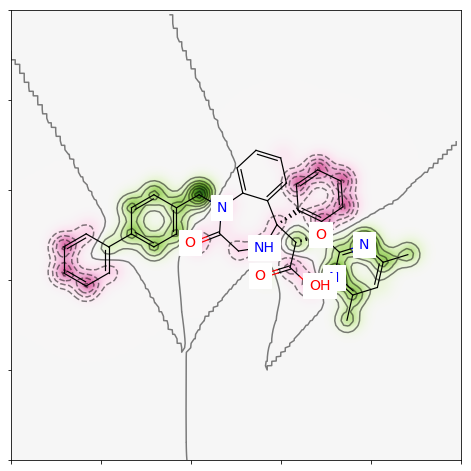
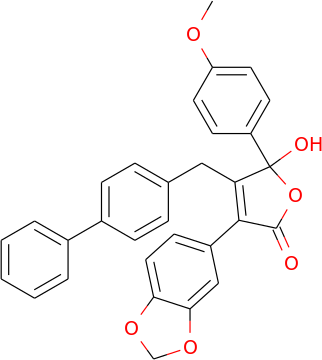
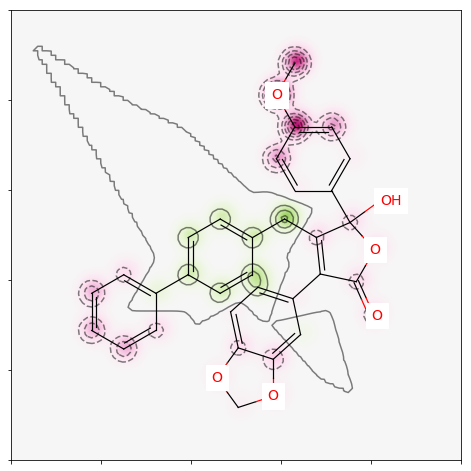
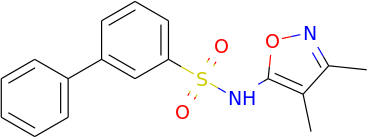
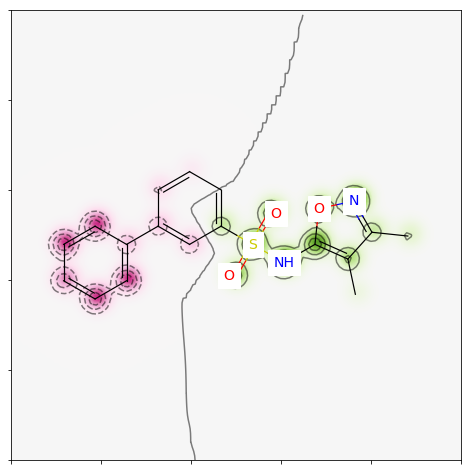
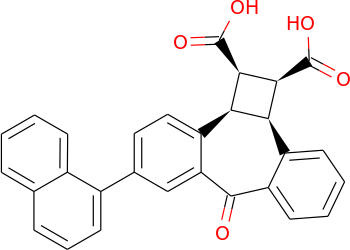
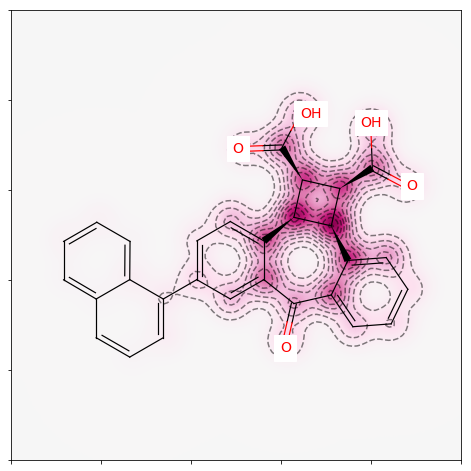

In [28]:
sample_list = test_list[:10]
sample_list.sort_list("ETA_pIC50")
sample_list.sim_map()

In [29]:
test_list.write_sim_map()

,ETA:,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>